In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import analysis
import processing
import runner
import matplotlib.pyplot as plt
import scipy

from scipy.signal import hilbert

/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/models
/Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/plots_out


# Synchronization

In [9]:
# TODO: load persisted model to skip training time
model = runner.run(modified_params={
    "N_pop": 2
}, file_name="coupled_synch")

initializing net ...
initialization time: 0.5202598571777344s
------------------ running network!
runtime: 14.4


INFO       width adjusted from 10. ms to 10.05 ms [brian2.monitors.ratemonitor.adjusted_width]


In [2]:
if 'model' not in locals() or model is None:
    model = analysis.load_model("coupled_synch")

In [3]:
lfp1, lfp2 = processing.lfp_nets(model)

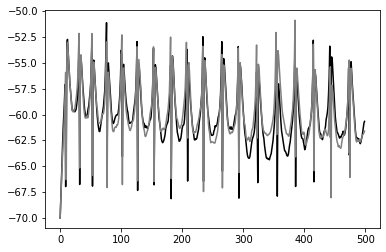

In [21]:
plt.plot(lfp1, c="black")
plt.plot(lfp2, c="grey")
plt.show()

## Phase Synchronization

* http://www.scholarpedia.org/article/Synchronization_measures#Phase_synchronization
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html

Phase Difference plot shows promising results. However, there are still some extreme values that we should filter out.
Maybe limit to certain frequency spectrum?


Phase difference of: 0.0
Phase difference of: 0.0
Phase difference of: -5.182808967281279e-05
Phase difference of: 1.5412627284216995e-06


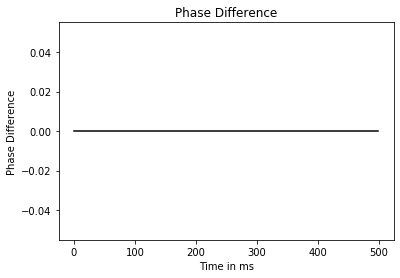

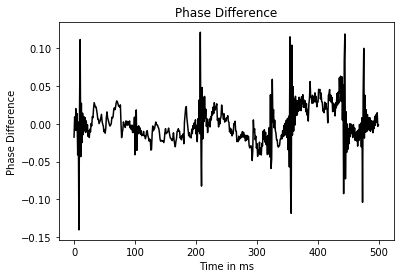

In [4]:
def hilphase(y1,y2):
    sig1_hill=hilbert(y1)
    sig2_hill=hilbert(y2)
    pdt=(np.inner(sig1_hill,np.conj(sig2_hill)) / (np.sqrt(np.inner(sig1_hill,
               np.conj(sig1_hill))*np.inner(sig2_hill,np.conj(sig2_hill)))))
    phase = np.angle(pdt)
    return phase

def hilphase_2(y1,y2):
    sig1_hill=hilbert(y1)
    sig2_hill=hilbert(y2)
    
    phase_y1=np.unwrap(np.angle(sig1_hill))
    phase_y2=np.unwrap(np.angle(sig2_hill))
    
    Inst_phase_diff=phase_y1-phase_y2
    avg_phase=np.average(Inst_phase_diff)
    
    return Inst_phase_diff,avg_phase

def plot_avg_phase_diff(sig1, sig2):
    phase = hilphase(sig1, sig2)
    print("Phase difference of:", phase)
    
    phase_diff, avg_phase = hilphase_2(sig1, sig2)
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(phase_diff, color="black")
    ax.set_title("Phase Difference")
    ax.set_xlabel("Time in ms")
    ax.set_ylabel("Phase Difference")
    plt.show()
    
    print("Phase difference of:", avg_phase)

plot_avg_phase_diff(lfp1, lfp1)    
plot_avg_phase_diff(lfp1, lfp2)

WARNING    /Users/lrebscher/git/Synchronization-by-Uncorrelated-Noise/venv/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
 [py.warnings]


Text(0.5, 1.0, 'Instantaneous Phase')

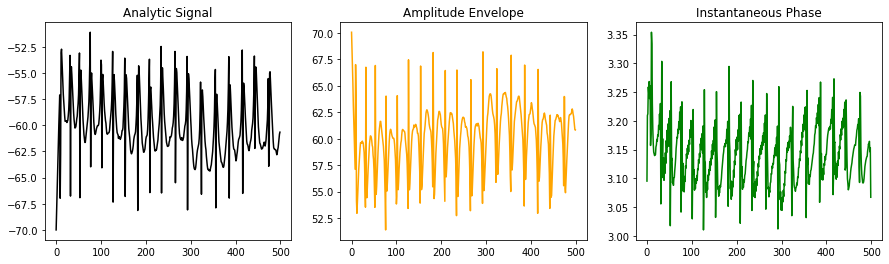

In [17]:
analytic_signal = hilbert(lfp1)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal))

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].plot(analytic_signal, c='black')
axs[0].set_title("Analytic Signal")

axs[1].plot(amplitude_envelope, c='orange')
axs[1].set_title("Amplitude Envelope")

axs[2].plot(instantaneous_phase, c='green')
axs[2].set_title("Instantaneous Phase")



## Cross Correlate

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html

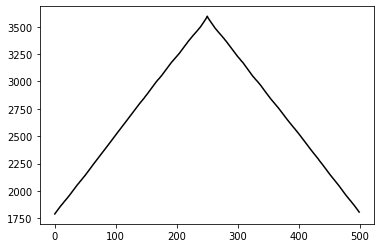

In [24]:
correlate = scipy.signal.correlate(lfp1, lfp2, mode='same') / lfp1.shape[0]
plt.plot(correlate, c="black")

## Coherence

* https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.coherence.html

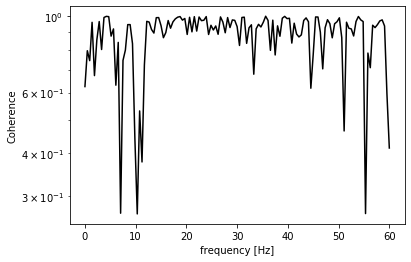

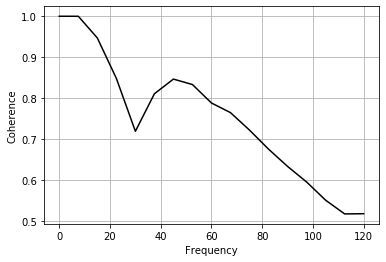

In [23]:
f, Cxy = scipy.signal.coherence(lfp1, lfp2, fs=120)
plt.semilogy(f, Cxy, c="black")
plt.xlabel('frequency [Hz]')
plt.ylabel('Coherence')
plt.show()

# NFFT: block size for FFT,  32ms blocks
Cxy, freqs = plt.cohere(lfp1, lfp2, NFFT=32, Fs=240, c="black")
plt.show()
